In [74]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [75]:
# Camera Calibration
def camera_calibration(images, nx, ny):
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    img_size = (1280, 720)
    
    for frame in tqdm(images):
        img = mpimg.imread(frame)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    return mtx, dist
    
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

100%|██████████| 20/20 [00:01<00:00, 10.62it/s]


In [76]:
# Correction for Distortion
images = glob.glob("camera_cal/calibration*.jpg")
def cal_undistort(img, objpoints, imgpoints):
    for frame in tqdm(images):
        img = mpimg.imread(frame)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        plt.imshow(undist)
    return undist

In [77]:
# Perspective Transform- Warp
img_size = (1280, 720)
def corners_unwarp(img, nx, ny, mtx, dist):
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            dst = np.float32([[100, 100], [1150,100], [1150, 650], [100, 650]])
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

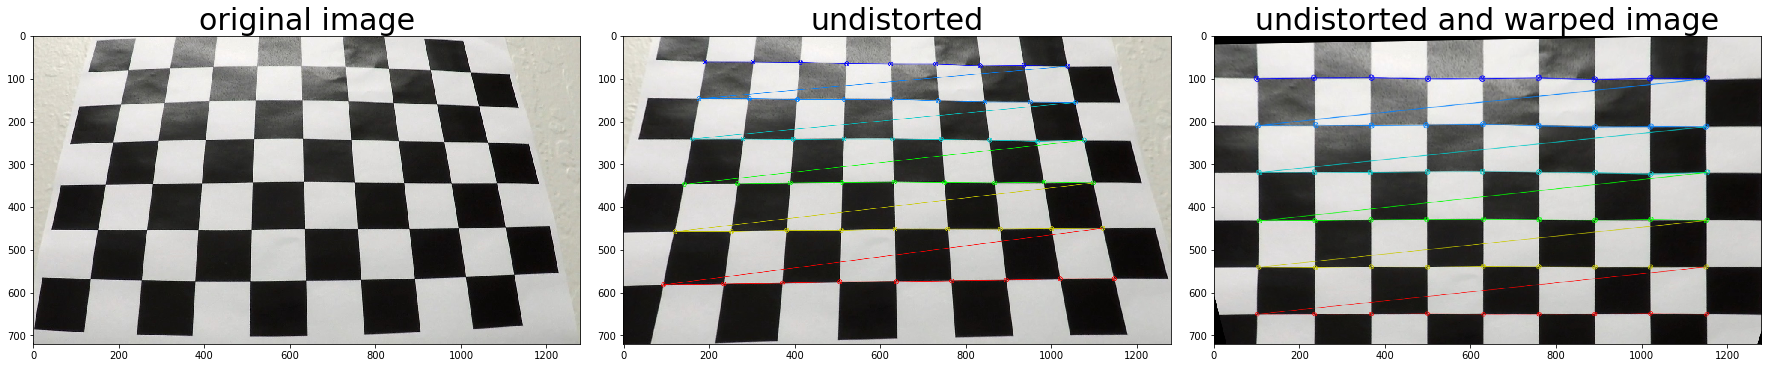

In [78]:
img = mpimg.imread("camera_cal/calibration3.jpg")
nx = 9
ny = 6
#img = camera_calibration(img, nx, ny)
#undist = cal_undistort(img, objpoints, imgpoints)
undist = cv2.undistort(img, mtx, dist, None, mtx)


top_down, perspective_M = corners_unwarp(undist, nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=30)
ax3.imshow(top_down)
ax3.set_title('undistorted and warped image', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [79]:
def get_thresholded_image(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
 
def combined_img(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    return color_combined
    
   
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

(<matplotlib.image.AxesImage at 0x7f40cf837588>, Text(0.5,1,'Threshold_Image'))

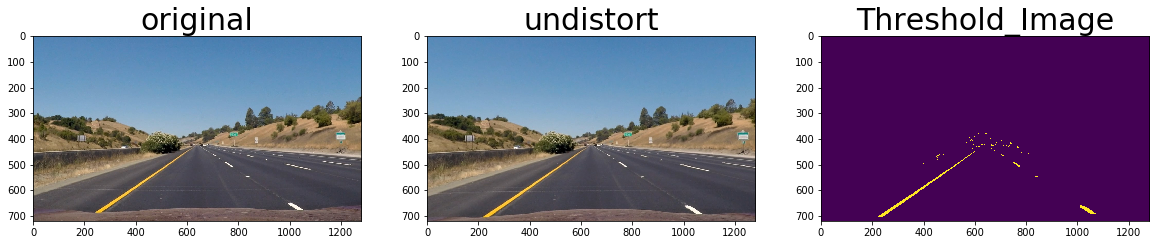

In [80]:
img = mpimg.imread('test_images/straight_lines1.jpg')
thresholded = get_thresholded_image(img)
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(thresholded, cmap='gray')
#ax2.set_title('Thresholded Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, axs = plt.subplots(1, 3, figsize=(20, 9))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
axs[1].imshow(undist), axs[1].set_title('undistort', fontsize=30)
axs[2].imshow(thresholded), axs[2].set_title('Threshold_Image', fontsize=30)

(<matplotlib.image.AxesImage at 0x7f40cf69d9e8>, Text(0.5,1,'ROI'))

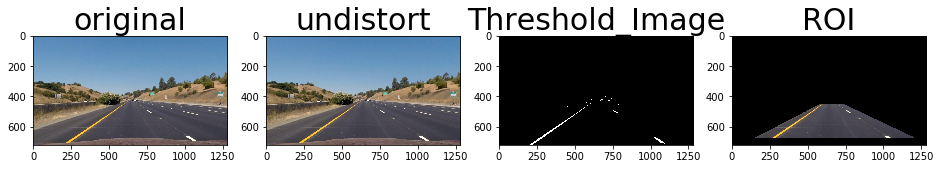

In [81]:
# Region of Interest
left_bottom = (150, 672)
left_top = (580, 450)
right_bottom = (1200, 672)
right_top = (730, 450)
roi_points = [[left_top, right_top, right_bottom, left_bottom]]

def region_of_interest(img, roi_points):
    mask = np.zeros_like(img)
    vertices = np.array(roi_points, dtype=np.int32)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
thresholded = get_thresholded_image(img)
roi= region_of_interest(img, roi_points)

f, axs = plt.subplots(1, 4, figsize=(16, 8))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
axs[1].imshow(undist), axs[1].set_title('undistort', fontsize=30)
#ax2.imshow(thresholded, cmap='gray')
axs[2].imshow(thresholded, cmap='gray'), axs[2].set_title('Threshold_Image', fontsize=30)
axs[3].imshow(roi), axs[3].set_title('ROI', fontsize=30)


(<matplotlib.image.AxesImage at 0x7f40e00954a8>, Text(0.5,1,'Unwarped_Image'))

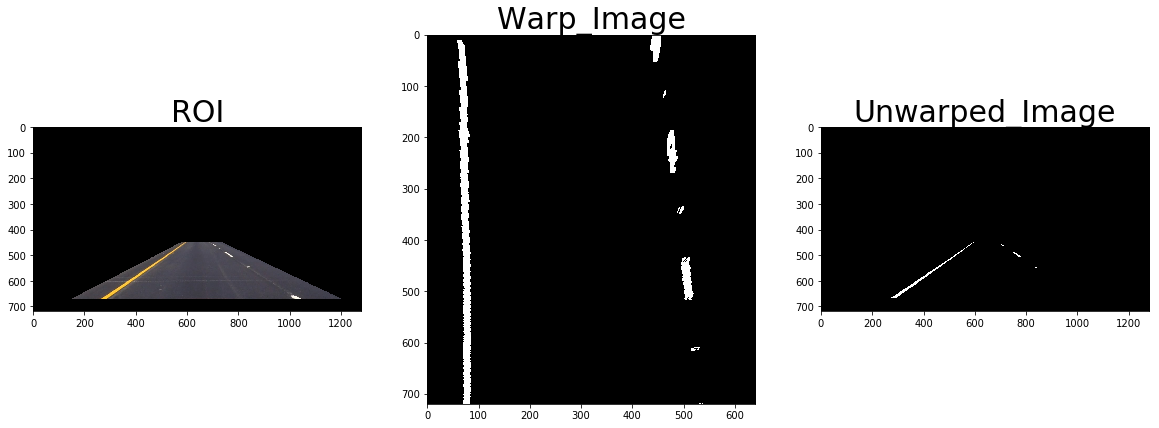

In [82]:
# Warp
def warp(img, roi_points):
    src = np.float32(roi_points)
    dst = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    thresholded = get_thresholded_image(img)
    warped = cv2.warpPerspective(thresholded, M, (640, 720), flags=cv2.INTER_LINEAR)    
    return warped

# Rewarp
def rewarp(img, roi_points):
    dst = np.float32(roi_points)
    src = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    rewarped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    return rewarped

img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
thresholded = get_thresholded_image(img)
roi= region_of_interest(img, roi_points)
warped = warp(roi, roi_points)
rewarped = rewarp(warped, roi_points)


f, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(roi, cmap='gray'), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('Warp_Image', fontsize=30)
axs[2].imshow(rewarped, cmap='gray'), axs[2].set_title('Unwarped_Image', fontsize=30)

([<matplotlib.lines.Line2D at 0x7f40cf5dbba8>], Text(0.5,1,'histogram'))

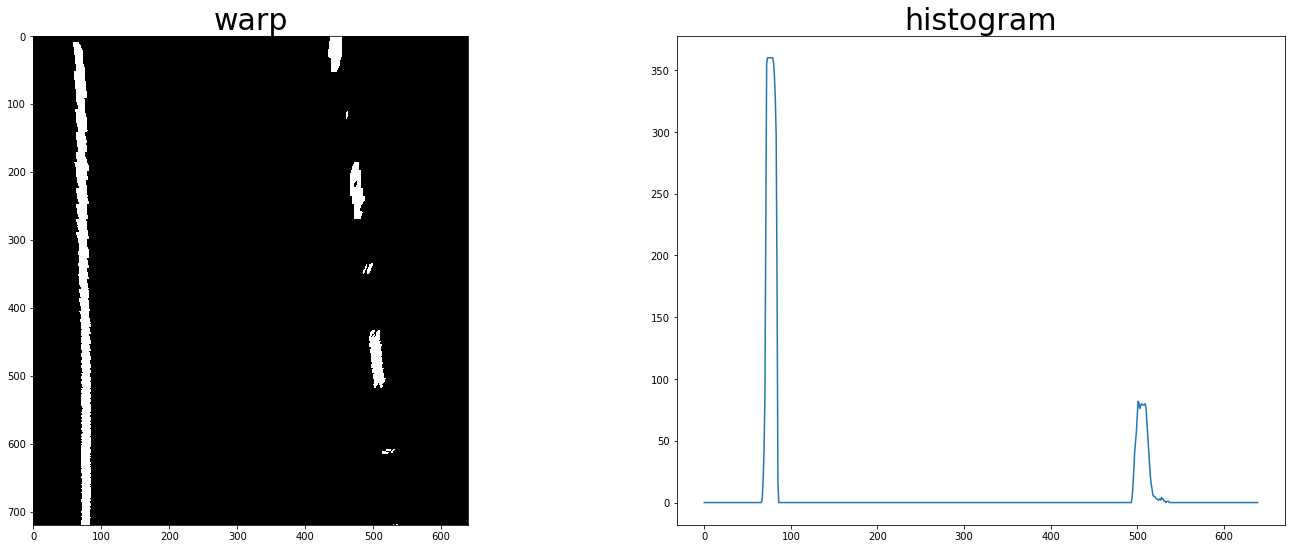

In [83]:
img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
thresholded = get_thresholded_image(img)
roi= region_of_interest(img, roi_points)
warped = warp(roi, roi_points)

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

#plt.plot(histogram)

f, axs = plt.subplots(1, 2, figsize=(24, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)

(<matplotlib.image.AxesImage at 0x7f40cf4f52e8>, Text(0.5,1,'window'))

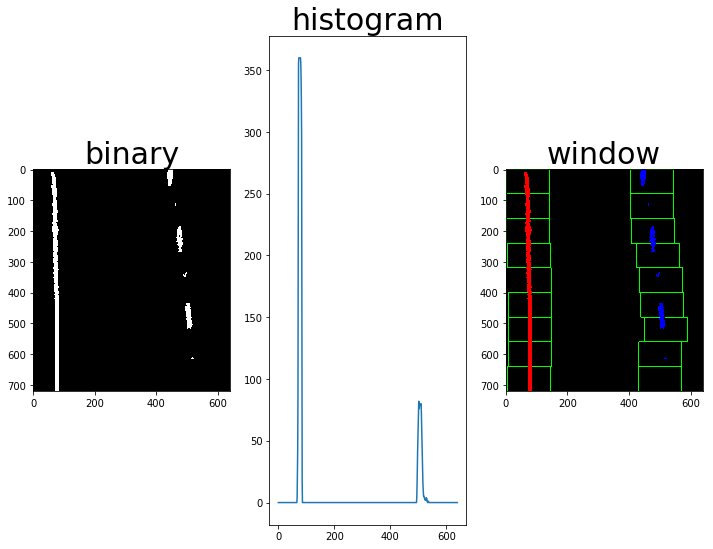

In [84]:
# Sliding Windows
def nonzero(warped):
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

def sliding_windows(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    nonzerox, nonzeroy = nonzero(warped)
    
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    # the number of sliding windows
    nwindows = 9
    # set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # current positions to be updated for each window
    left_current = left_base
    right_current = right_base
    # set with width of the windows +/- margin
    margin = 70
    # set minimum number of pixels found to recenter window
    minpix = 50
    # create empty lists to receive left and right lane pixel indices
    left_inds = []
    right_inds = []

    # step through the windows one by one
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_low = warped.shape[0] - (window + 1) * window_height
        win_high = warped.shape[0]- window * window_height
        win_left_left = left_current - margin
        win_left_right = left_current + margin
        win_right_left = right_current - margin
        win_right_right = right_current + margin
        # draw the windows on the visualization image
        cv2.rectangle(out, (win_left_left, win_low), (win_left_right, win_high), (0, 255, 0), 2)
        cv2.rectangle(out, (win_right_left, win_low), (win_right_right, win_high), (0, 255, 0), 2)
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_left_left) & (nonzerox < win_left_right)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_right_left) & (nonzerox < win_right_right)).nonzero()[0]
        # append these indices in this window to the list of all windows
        left_inds.append(good_left_inds)
        right_inds.append(good_right_inds)
        # if you found > minpix pixels, recenter next window on theri mean position
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
                   
    # concatenate all the arrays of indices
    left_inds = np.concatenate(left_inds)  
    right_inds = np.concatenate(right_inds)
    
    # draw left and right lane lines     
    out[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
    out[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
    
    return [left_inds, right_inds]

img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)

#R = warped[:,:,0]
#r_binary = rgb_thresh(warped, 0, (150, 255))
#out = np.dstack((r_binary, r_binary, r_binary)) ** 255
out = np.dstack((warped, warped, warped)) ** 255
indices = sliding_windows(warped)
        
f, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('window', fontsize=30)

[array([ -1.94014734e-05,   3.01111017e-02,   6.65054347e+01]), array([ -6.49062597e-05,   1.66249891e-01,   4.41154198e+02])]


([<matplotlib.lines.Line2D at 0x7f40cf414390>],
 [<matplotlib.lines.Line2D at 0x7f40cf414860>])

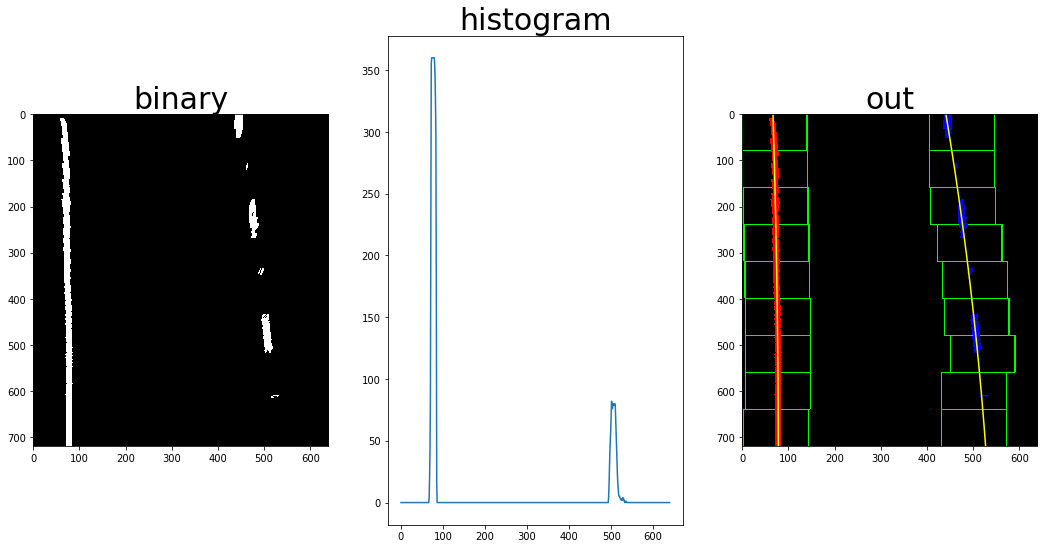

In [85]:
# Polynomial Fit
def fit_polynomial(warped, indices, polynomial):
    # divide left and right indices
    left_inds = indices[0]
    right_inds = indices[1]
    
    if (len(left_inds)==0 | len(right_inds)==0):
        return polynomial
    
    nonzerox, nonzeroy = nonzero(warped)
    
    # extract x and y of lane line pixel by indices
    leftx = nonzerox[left_inds]
    lefty = nonzeroy[left_inds]
    rightx = nonzerox[right_inds]
    righty = nonzeroy[right_inds]

    # fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if((polynomial != []) & (left_fit[0] * right_fit[0] < 0.)):
        if(np.absolute(left_fit[1] - polynomial[0][1]) > 0.1):
            left_fit[0] = right_fit[0]
            left_fit[1] = right_fit[1]
            left_fit[2] = right_fit[2] - 450
        if(np.absolute(right_fit[1] - polynomial[1][1]) > 0.1):
            right_fit[0] = left_fit[0]
            right_fit[1] = left_fit[1]
            right_fit[2] = left_fit[2] + 450
    
#     print(left_fit, polynomial)
#     if((polynomial != []) & (np.absolute(left_fit[2] - polynomial[0][2]) > 60)):
#         left_fit = polynomial[0]
    
    return [left_fit, right_fit]

# generate x and y values for plotting
def calculate_lane(polynomial):
    left_poly = polynomial[0]
    right_poly = polynomial[1]
    ploty = np.linspace(0, 719, 720)
    left_fitx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2] 
    right_fitx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
    return [left_fitx, right_fitx]
    
img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
#xhl_binary = xhl_thresh(warped, (4, 100), (18, 50), (195, 255))
#R = warped[:,:,0]
#r_binary = rgb_thresh(warped, 0, (150, 255))
#out = np.dstack((r_binary, r_binary, r_binary)) ** 255
#indices = sliding_windows(r_binary)
out = np.dstack((warped, warped, warped)) ** 255
indices = sliding_windows(warped)
polynomial = fit_polynomial(warped, indices, [])
print(polynomial)
laneline = calculate_lane(polynomial)
ploty = np.linspace(0, 719, 720)

f, axs = plt.subplots(1, 3, figsize=(18, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('out', fontsize=30)
axs[2].plot(laneline[0], ploty, color='yellow'), axs[2].plot(laneline[1], ploty, color='yellow')



[array([ -1.94014734e-05,   3.01111017e-02,   6.65054347e+01]), array([ -6.49062597e-05,   1.66249891e-01,   4.41154198e+02])]


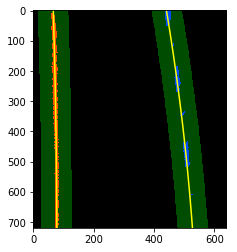

In [86]:
# Finding Lines
# tuning windows around the sliding windows or previous tuning windows
def tuning_windows(polynomial, warped_binary):
    left_poly = polynomial[0]
    right_poly = polynomial[1]
    ploty = np.linspace(0, 719, 720)
    nonzerox, nonzeroy = nonzero(warped_binary)  
    margin = 100

    # using pervious fit of polynomial to perdict the position of indices of lane line
    left_pre = left_poly[0] * nonzeroy ** 2 + left_poly[1] * nonzeroy + left_poly[2]
    right_pre = right_poly[0] * nonzeroy ** 2 + right_poly[1] * nonzeroy + right_poly[2]
    
    # find indices position in warp between prediction +/- margin
    left_inds = ((nonzerox > left_pre - margin) & (nonzerox < left_pre + margin))
    right_inds = ((nonzerox > right_pre - margin) & (nonzerox < right_pre + margin))
    
    return [left_inds, right_inds]

def tuning_draw(laneline, indices, warped_binary):
    left_fitx = laneline[0]
    right_fitx = laneline[1]
    ploty = np.linspace(0, 719, 720)
    nonzerox, nonzeroy = nonzero(warped_binary)  
    # create an image to draw on and an image to show the selection window
    out = np.dstack((warped_binary, warped_binary, warped_binary)) ** 255
    window = np.zeros_like(out)

    margin = 50
    # generate a polygon to illustrate the search window area and recast the x and y points into usable format for cv2.fillPoly()
    left_window1 = np.array([np.transpose(np.vstack([laneline[0] - margin, ploty]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([laneline[0] + margin, ploty])))])
    left_pts = np.hstack((left_window1, left_window2))
    right_window1 = np.array([np.transpose(np.vstack([laneline[1] - margin, ploty]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([laneline[1] + margin, ploty])))])
    right_pts = np.hstack((right_window1, right_window2))

    # color in left and right line pixels
    out[nonzeroy[indices[0]], nonzerox[indices[0]]] = [255, 0, 0]
    out[nonzeroy[indices[1]], nonzerox[indices[1]]] = [0, 0, 255]

    # draw the lane onto the warped blank image
    cv2.fillPoly(window, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(window, np.int_([right_pts]), (0, 255, 0))
    result = cv2.addWeighted(out, 1, window, 0.3, 0)
    
    return result


# the next frame of the video 
img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
#xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
#R = warped[:,:,0]
#r_binary = rgb_thresh(warped, 0, (150, 255))
indices = tuning_windows(polynomial, warped)
polynomial_new = fit_polynomial(warped, indices, [])
print(polynomial_new)
laneline = calculate_lane(polynomial_new)
result = tuning_draw(laneline, indices, warped)


plt.imshow(result)
plt.plot(laneline[0], ploty, color='yellow')
plt.plot(laneline[1], ploty, color='yellow')


(1505.4223833202664, 1504.4786529043233)


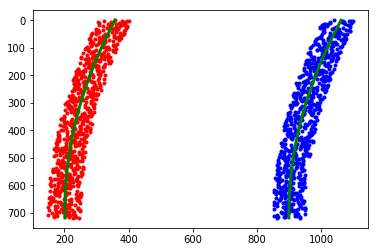

In [87]:
# generate some fake data to represent lane0line pixels
ploty = np.linspace(0, 719, num=720) # to cover some y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# for each y position generate random x position with +/- 50 pix
leftx = np.array([200 + quadratic_coeff * y ** 2 + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + quadratic_coeff * y ** 2 + np.random.randint(-50, high=51) for y in ploty])

# reverse to match top-to-bottom in y
leftx = leftx[::-1]
rightx = rightx[::-1]

# fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
right_fit = np.polyfit(ploty, rightx, 2)

# calculate x for draw
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]


def curvature_pixel(left_fit, right_fit, y_eval):
    # the radius of curvature corresponding to the bottom of the image
    left_curcerad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curcerad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    return left_curcerad, right_curcerad

print(curvature_pixel(left_fit, right_fit, 720))

# plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [88]:

# conversions in x and y from pixels space to meters
def curvature_meter(polynomial, ym, xm, y_eval):
    left_fit = polynomial[0]
    right_fit = polynomial[1]
    
    # pixel function to meter function
    l_A = left_fit[0] * xm / (ym ** 2)
    l_B = left_fit[1] * xm / ym
    
    # pixel function to meter function
    r_A = right_fit[0] * xm / (ym ** 2)
    r_B = right_fit[1] * xm / ym

    # calculate the new radius of curvature
    left_curcerad = ((1 + (2 * l_A * y_eval * ym + l_B) ** 2) ** 1.5) / np.absolute(2 * l_A)
    right_curcerad = ((1 + (2 * r_A * y_eval * ym + r_B) ** 2) ** 1.5) / np.absolute(2 * r_A)
    return left_curcerad, right_curcerad

left_curcerad, right_curcerad = curvature_meter([left_fit, right_fit], 30 / 720, 3.7 / 500, 720)
print(left_curcerad, 'm', right_curcerad, 'm')

352.907228694 m 356.856323091 m


[array([ -1.94014734e-05,   3.01111017e-02,   6.65054347e+01]), array([ -6.49062597e-05,   1.66249891e-01,   4.41154198e+02])]


(<matplotlib.image.AxesImage at 0x7f40cf138400>, Text(0.5,1,'result'))

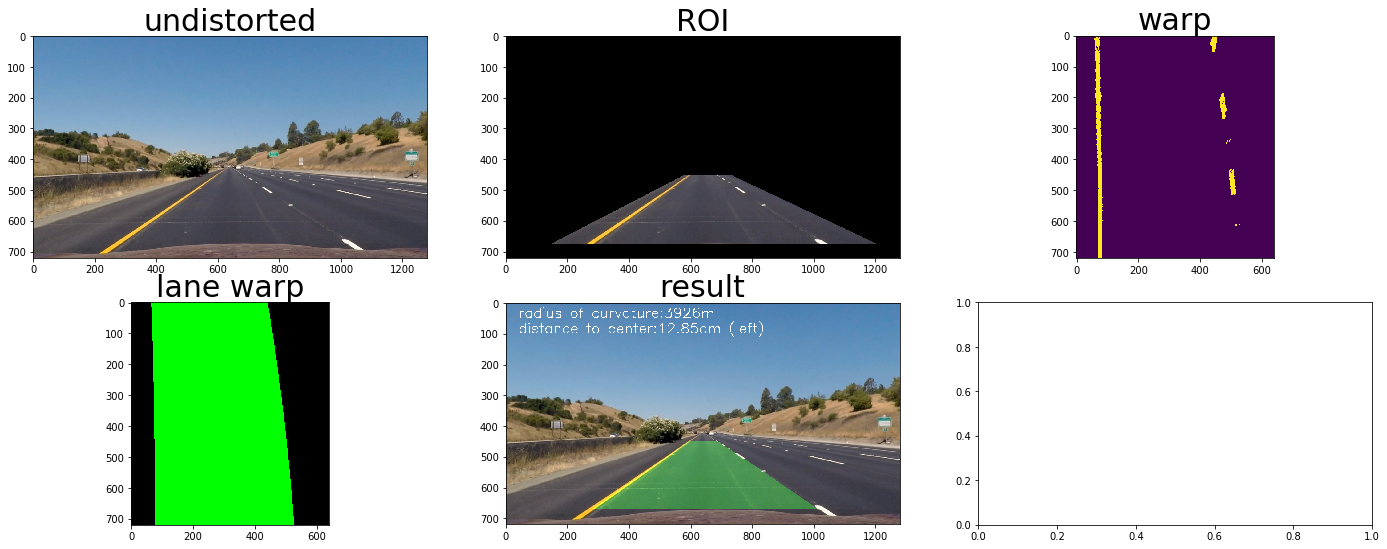

In [89]:
def warp_lane(warped, laneline):
    # create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    lane_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, 720)
    left_pts = np.array([np.transpose(np.vstack([laneline[0], ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([laneline[1], ploty])))])
    pts = np.hstack((left_pts, right_pts))

    # draw the lane onto the warped blank image
    cv2.fillPoly(lane_warp, np.int_([pts]), (0, 255, 0))
    
    return lane_warp

def curvature_distance(laneline, polynomial):
    left_curcerad, right_curcerad = curvature_meter(polynomial, 30 / 720, 3.7 / 500, 720)
    curvature = int((left_curcerad + right_curcerad) / 2)
    distance = round(((laneline[0][-1] + laneline[1][-1]) / 2 - 320) * 3.7 / 5, 2)
    
    return curvature, distance

def draw_result(undist, lane_warp, roi_points, curvature, distance):
    # warp the blank back to original image space using inverse perspective matrix
    rewarped = rewarp(lane_warp, roi_points)
    result = cv2.addWeighted(undist, 1, rewarped, 0.3, 0)
    result = cv2.putText(result, 'radius of curvature:' + str(curvature) + 'm', (40, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    if (distance > 0):
        result = cv2.putText(result, 'distance to center:' + str(distance) + 'cm ' + '(right)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    else:
        result = cv2.putText(result, 'distance to center:' + str(-distance) + 'cm ' + '(left)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    return result

img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(undist, roi_points)
#R = warped[:,:,0]
#r_binary = rgb_thresh(warped, 0, (150, 255))
out = np.dstack((warped, warped, warped)) ** 255
indices = tuning_windows(polynomial, warped)
polynomial_new = fit_polynomial(warped, indices, [])
print(polynomial)
laneline = calculate_lane(polynomial)
curvature, distance = curvature_distance(laneline, polynomial)
lane_warp = warp_lane(warped, laneline)
result = draw_result(undist, lane_warp, roi_points, curvature, distance)


f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0,0].imshow(undist), axs[0,0].set_title('undistorted', fontsize=30)
axs[0,1].imshow(roi), axs[0,1].set_title('ROI', fontsize=30)
axs[0,2].imshow(warped), axs[0,2].set_title('warp', fontsize=30)
axs[1,0].imshow(lane_warp), axs[1,0].set_title('lane warp', fontsize=30)
axs[1,1].imshow(result), axs[1,1].set_title('result', fontsize=30)

[array([ -2.58843329e-04,   3.85834027e-01,  -2.49178678e+01]), array([ -1.33429337e-04,   3.89728056e-01,   3.75836190e+02])]
[array([ -2.58843329e-04,   3.85834027e-01,  -2.49178678e+01]), array([ -2.66297958e-04,   4.94503737e-01,   3.57419891e+02])]


(<matplotlib.image.AxesImage at 0x7f40ceff4eb8>, Text(0.5,1,'after'))

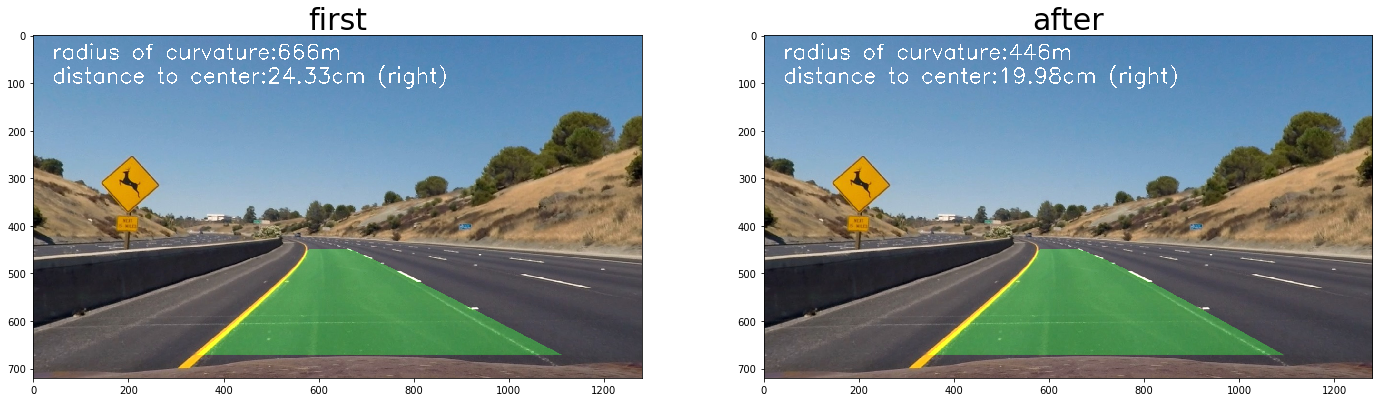

In [90]:
# Pipeline
def process_sliding(img, mtx, dist, polynomial):  
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    comb_img = combined_img(img)
    roi = region_of_interest(undist, roi_points)
    warped = warp(roi, roi_points)
    src = np.float32(roi_points)
    dst = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    #xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
    #R = warped[:,:,0]
    #r_binary = rgb_thresh(warped, 0, (150, 255))
    indices = sliding_windows(warped)    
    polynomial_new = fit_polynomial(warped, indices, polynomial)
    laneline = calculate_lane(polynomial_new)
    curvature, distance = curvature_distance(laneline, polynomial_new)
    lane_warp = warp_lane(warped, laneline)
    result = draw_result(undist, lane_warp, roi_points, curvature, distance)
    
    return result, polynomial_new, comb_img, undist, Minv

def process_tuning(img, mtx, dist, polynomial):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    roi = region_of_interest(undist, roi_points)
    warped = warp(roi, roi_points)
    #xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
    #R = warped[:,:,0]
    #r_binary = rgb_thresh(warped, 0, (150, 255))
    indices = tuning_windows(polynomial, warped)
    polynomial_new = fit_polynomial(warped, indices, polynomial)
    laneline = calculate_lane(polynomial_new)
    curvature, distance = curvature_distance(laneline, polynomial_new)
    lane_warp = warp_lane(warped, laneline)
    result = draw_result(undist, lane_warp, roi_points, curvature, distance)
    
    return result, polynomial_new
    
result1, polynomial, comb_img, undist, Minv = process_sliding(mpimg.imread("test_images/test2.jpg"), mtx, dist, [])
print(polynomial)
result2, polynomial = process_tuning(mpimg.imread("test_images/test2.jpg"), mtx, dist, polynomial)
print(polynomial)
# result2 = cv2.cvtColor(result2, cv2.COLOR_RGB2BGR)
# cv2.imwrite("output_images/s2.jpg", result2)

f, axs = plt.subplots(1, 2, figsize=(24, 9))
axs[0].imshow(result1), axs[0].set_title('first', fontsize=30)
axs[1].imshow(result2), axs[1].set_title('after', fontsize=30)

In [18]:
"""
#Video to frames
import cv2
import os
from os.path import isfile, join


vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
i = 0 

while success:
  cv2.imwrite("Frames/%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

"""


In [3]:
"""
img=glob.glob("Frames/%d*.jpg")
result, polynomial = process_sliding(mpimg.imread("Frames/1259.jpg"), mtx, dist, [])
for i in tqdm(range(0, len(img))):
    #img = mpimg.imread("Frames/new%d.jpg" % i) 
#for i in range(1259):
    if (i % 5 == 0):
        result, polynomial = process_sliding(mpimg.imread("Frames/%d.jpg" % (0 + i)), mtx, dist, polynomial)
    else:
        result, polynomial = process_tuning(mpimg.imread("Frames/%d.jpg" % (0 + i)), mtx, dist, polynomial)
        
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite("output_images/%d.jpg" % (i + 1259), result)
    
"""

NameError: name 'process_sliding' is not defined

In [91]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
def update_lane_data(left_fit, right_fit, left_fitx, right_fitx):
    left_lane.best_fit = left_fit
    right_lane.best_fit = right_fit
    left_lane.allx = left_fitx
    right_lane.allx = right_fitx
    
def lanes_found(binary_warped):
    min_peak_found = 50
    histogram = np.sum(warped[warped.shape[0]//2:, :], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if leftx_base < min_peak_found or rightx_base < min_peak_found:
        return False
    return True

def sanity_check_pass(left_fit, right_fit):
    # Similar Curvature
    diff = abs(left_lane.radius_of_curvature - right_lane.radius_of_curvature)
    if diff > 500:
        return False
    left_fit_diff = np.abs(left_fit[0] - left_lane.best_fit[0])
    left_check = min(abs(left_fit[0]), abs(left_lane.best_fit[0])) / left_fit_diff
    right_fit_diff = np.abs(right_fit[0] - right_lane.best_fit[0])
    right_check = min(abs(right_fit[0]), abs(right_lane.best_fit[0])) / right_fit_diff
    if left_check <= 0.5 or right_check <= 0.5:
        return False
    # Lines separated by approximately the right distance
    return True

In [104]:

def process_video(img):
    #global frames_used   
    global frames_not_detected_line
    #frames_used += 1
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    comb_img, undistort_img, M_inv = process_sliding(img)  
    
    if left_lane.detected == False and right_lane.detected == False:
        out_img,left_fit, left_fitx,leftx,lefty,right_fit,right_fitx,rightx,righty,left_lane_inds, right_lane_inds = window_search(combined_img)        
        center_curve,left_curve, right_curve, center_dis = curverad(comb_img,left_fitx, right_fitx)
        #print(center_curve,left_curve, right_curve, center_dis)
        left_lane.radius_of_curvature = left_curve
        right_lane.radius_of_curvature = right_curve
        left_lane.line_base_pos = center_dis
        left_lane.detected = True
        right_lane.detected = True
        update_lane_data(left_fit, right_fit, left_fitx, right_fitx)
    else:
        if lanes_found(combined_img) and frames_not_detected_line <= 1:
            left_fit_new, right_fit_new,left_fit, right_fit,leftx,lefty,rightx,righty,left_lane_inds, right_lane_inds= polyfit_using_prev_fit(comb_img, left_lane.best_fit, right_lane.best_fit)
            if sanity_check_pass(left_fit_new, right_fit_new) == True:
                update_lane_data(left_fit, right_fit,left_fit_new, right_fit_new)
                center_curve,left_curve, right_curve, center_dis = curverad(comb_img,left_fit_new, right_fit_new)
                #print(center_curve,left_curve, right_curve, center_dis)
                left_lane.radius_of_curvature = left_curve
                right_lane.radius_of_curvature = right_curve
                left_lane.line_base_pos = center_dis
            else:
                frames_not_detected_line += 1
                
        else:
            left_lane.detected = False
            right_lane.detected = False
            frames_not_detected_line = 0
    
    result = project_lines(comb_img,left_lane.best_fit, right_lane.best_fit, M_inv, undistort_img)
    output_image = write_on_Image(result, left_lane.radius_of_curvature, right_lane.radius_of_curvature,left_lane.line_base_pos)
    return output_image

In [105]:
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_video)
%time processed_video.write_videofile(video_output1, audio=False)

TypeError: process_sliding() missing 3 required positional arguments: 'mtx', 'dist', and 'polynomial'

In [36]:
import cv2
import os
from os.path import isfile, join

size = (1280, 720)
#image = mpimg.imread("test_images/straight_lines1.jpg")

def convert_pictures_to_video(pathIn, pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files = sorted(files)
    for i in range(len(files)):
        filename=pathIn + files[i]
    
        #reading each files
        img = cv2.imread(filename)
        #height, width, layers = img.shape
        #size = (width,height)
    
        #for k in range (time):
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

directory = 'output_images'
#directory = 'Frames'
pathIn = directory + '/'
pathOut = pathIn + 'output_video.avi'
fps = 20
#time = 4
convert_pictures_to_video(pathIn, pathOut,fps)

print("The video was successfully saved")

The video was successfully saved
